# PAMTRA: riming dependent parameterization using SSRGA 
## Full-bin interface example with HALO-(AC)³ data

Here, we show how the riming dependet parameterization from Maherndl et al.(2023a, in revision) can be used in PAMTRA to simulate radar spectra of rimed ice particles. We use measured, binned particle size distributions. This is not only applicable to in situ measurements, but also to atmospheric models with full bin microphysics.

The script requires `haloac3_dataset_for_pamtra.nc` from the [example_data]("https://uni-koeln.sciebo.de/s/28700CuFssmin8q"). 

Start with importing the required libraries and setting up the Notebook to show plots inline.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import pyPamtra

%matplotlib inline

/home/nmaherndl/lib/python/pyPamtra/meteoSI.py:19: Warning: numexpr not available
  warnings.warn("numexpr not available", Warning)
/home/nmaherndl/lib/python/pyPamtra/importer.py:26: Warning: numexpr not available
  warnings.warn("numexpr not available", Warning)


Open the HALO-(AC)³ example data set (link). To keep file size small, the file contains only observations of a single cloud. See Mech et al. (2022, https://www.nature.com/articles/s41597-022-01900-7), Moser et al. (2023, https://acp.copernicus.org/preprints/acp-2023-44/) and Maherndl et al. (2023b, submitted) for details of the processing. 

In [2]:
data = xr.load_dataset('haloac3_dataset_for_pamtra.nc')

In [3]:
data

<xarray.Dataset>
Dimensions:        (time: 114, height: 1400, bin_mid: 95)
Coordinates:
  * time           (time) datetime64[ns] 2022-04-01T11:25:00 ... 2022-04-01T1...
  * height         (height) float32 -1e+03 -995.0 -990.0 ... 5.99e+03 5.995e+03
  * bin_mid        (bin_mid) float64 3.9 6.2 8.85 ... 6.489e+03 6.592e+03
Data variables: (12/19)
    Ze             (time, height) float64 -inf -inf -inf -inf ... -inf -inf -inf
    lon5           (time) float64 7.035 7.032 7.03 7.028 ... 6.75 6.748 6.745
    lat5           (time) float64 79.46 79.46 79.46 79.46 ... 79.49 79.49 79.49
    alt5           (time) float64 2.809e+03 2.809e+03 ... 2.807e+03 2.807e+03
    lon6           (time) float64 7.128 7.125 7.123 7.12 ... 6.856 6.853 6.851
    lat6           (time) float64 79.45 79.45 79.45 79.45 ... 79.48 79.48 79.48
    ...             ...
    Ze_mirac       (time) float64 1.15 1.328 1.539 ... -4.076 -4.304 -4.543
    Ze_att         (time) float64 0.5065 0.5065 0.5065 ... 0.4056 0.4056 0.4056
    M              (time) float64 0.04351 0.04429 0.0455 ... 0.02278 0.02244
    Ze_mirac_corr  (time) float64 1.656 1.835 2.046 ... -3.671 -3.898 -4.138
    psd_ice        (time, bin_mid) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    psd_liquid     (time, bin_mid) int64 918800663723 1893625985597 ... 0 0

Extract the particle size distributions (psd_ice and psd_liquid for ice particles and supercooled droplets) from the netCDF file. 

In [4]:
psd_i = np.ma.masked_invalid(data.psd_ice.values).filled(0)
psd_l = np.ma.masked_invalid(data.psd_liquid.values).filled(0)
nBins = np.shape(psd_i)[1]

Also, we save the average and bounding diameter of each size bin

In [5]:
Dmean = data.bin_mid.values*1e-6 # bc values in microns
Dbound = np.append(data.bin_min.values[:,0], data.bin_max.values[-1, 0])
Dbound = Dbound*1e-6

In [6]:
Dbound, Dmean

(array([3.0000e-06, 4.8000e-06, 7.6000e-06, 1.0100e-05, 1.1700e-05,
        1.3600e-05, 1.6000e-05, 1.7300e-05, 1.8700e-05, 2.0700e-05,
        2.2900e-05, 2.4600e-05, 2.6200e-05, 2.7600e-05, 2.9700e-05,
        3.1600e-05, 3.3500e-05, 3.5500e-05, 5.2500e-05, 6.7500e-05,
        8.2500e-05, 9.7500e-05, 1.1250e-04, 1.2750e-04, 1.4250e-04,
        1.5750e-04, 1.7250e-04, 1.8750e-04, 2.0250e-04, 2.1750e-04,
        2.3250e-04, 2.4750e-04, 2.6250e-04, 2.7750e-04, 2.9350e-04,
        4.6350e-04, 5.6650e-04, 6.6950e-04, 7.7250e-04, 8.7550e-04,
        9.7850e-04, 1.0815e-03, 1.1845e-03, 1.2875e-03, 1.3905e-03,
        1.4935e-03, 1.5965e-03, 1.6995e-03, 1.8025e-03, 1.9055e-03,
        2.0085e-03, 2.1115e-03, 2.2145e-03, 2.3175e-03, 2.4205e-03,
        2.5235e-03, 2.6265e-03, 2.7295e-03, 2.8325e-03, 2.9355e-03,
        3.0385e-03, 3.1415e-03, 3.2445e-03, 3.3475e-03, 3.4505e-03,
        3.5535e-03, 3.6565e-03, 3.7595e-03, 3.8625e-03, 3.9655e-03,
        4.0685e-03, 4.1715e-03, 4.2745e-03, 4.37

Next, we create an empty pyPamtra object

In [7]:
pam = pyPamtra.pyPamtra()

Even though we use the full-bin interface, we need to add a standard hydrometeor description to create the required data structures. For consistency, the same data fields are required as for the regular PAMTRA hydrometeor interface. However, many parameters are not relevant when using the full-bin interface. 

In [8]:
pam.df.addHydrometeor((
        "liquid",  # name 
        -99.,  # aspect ratio (NOT RELEVANT)
        1,  # liquid - ice flag
        -99.,  # density (NOT RELEVANT)
        -99.,  # mass size relation prefactor a (NOT RELEVANT)
        -99.,  # mass size relation exponent b (NOT RELEVANT)
        -99.,  # area size relation prefactor alpha (NOT RELEVANT)
        -99.,  # area size relation exponent beta (NOT RELEVANT)
        0,  # moment provided later (NOT RELEVANT)
        nBins,  # number of bins
        "fullBin",  # distribution name (NOT RELEVANT)
        -99.,  # distribution parameter 1 (NOT RELEVANT)
        -99.,  # distribution parameter 2 (NOT RELEVANT)
        -99.,  # distribution parameter 3 (NOT RELEVANT)
        -99.,  # distribution parameter 4 (NOT RELEVANT)
        -99.,  # minimum diameter (NOT RELEVANT)
        -99.,  # maximum diameter (NOT RELEVANT)
        'mie-sphere',  # scattering model
        'khvorostyanov01_drops',  # fall velocity relation
        0.0  # canting angle
    ))

In [9]:
pam.df.addHydrometeor((
    "ice",  # name ## "liquid" -> "ice"
    -99.,  # aspect ratio (NOT RELEVANT)
    -1,  # liquid - ice flag
    -99.,  # density (NOT RELEVANT)
    -99.,  # mass size relation prefactor a (NOT RELEVANT)
    -99.,  # mass size relation exponent b (NOT RELEVANT)
    -99.,  # area size relation prefactor alpha (NOT RELEVANT)
    -99.,  # area size relation exponent beta (NOT RELEVANT)
    0,  # moment provided later (NOT RELEVANT)
    nBins,  # number of bins
    "fullBin",  # distribution name (NOT RELEVANT)
    -99.,  # distribution parameter 1 (NOT RELEVANT)
    -99.,  # distribution parameter 2 (NOT RELEVANT)
    -99.,  # distribution parameter 3 (NOT RELEVANT)
    -99.,  # distribution parameter 4 (NOT RELEVANT)
    -99.,  # minimum diameter (NOT RELEVANT)
    -99.,  # maximum diameter (NOT RELEVANT)
    'ss-rayleigh-gans',  # scattering model ## SSRGA
    'heymsfield10_particles',  # fall velocity relation ## more realistic for ice particles
    0.0  # canting angle
))

Next, we add an an atmospheric profile to PAMTRA. For this example, we use an US standard profile for simplicity. The `pyPamtra.importer.createUsStandardProfile` helper routine requires only height levels as an input. The height dimension of level properties is one longer than for layer properties such as hydrometeor properties. Therefore, we need to add one more height level to the ACME-V data set. Here, we simply add a height value to the vector. For comparison with e.g. a ground-based radar, the height levels should be derived from the height layers through interpolation. 

In [10]:
pam = pyPamtra.importer.createUsStandardProfile(
    pam, 
    hgt_lev=list(data['alt6'].values) + [465]
)

/home/nmaherndl/lib/python/pyPamtra/core.py:821: Warning: timestamp set to now
  warnings.warn("timestamp set to now", Warning)
/home/nmaherndl/lib/python/pyPamtra/core.py:838: Warning: lat set to 50.938056
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/nmaherndl/lib/python/pyPamtra/core.py:838: Warning: lon set to 6.956944
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/nmaherndl/lib/python/pyPamtra/core.py:838: Warning: wind10u set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/nmaherndl/lib/python/pyPamtra/core.py:838: Warning: wind10v set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/nmaherndl/lib/python/pyPamtra/core.py:838: Warning: groundtemp set to nan
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/nmaherndl/lib/python/pyPamtra/core.py:838: Warning: sfc_salinity set to 33.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/nmaherndl/lib/pyth

Note that parameters not provided will be guessed, please make sure to look at the warning messages carefully. Now, the `pam.p` dictionary is created

In [11]:
sorted(pam.p.keys())

['airturb',
 'groundtemp',
 'hgt',
 'hgt_lev',
 'hydro_n',
 'hydro_q',
 'hydro_reff',
 'lat',
 'lon',
 'max_nlyrs',
 'model_i',
 'model_j',
 'ngridx',
 'ngridy',
 'nlyrs',
 'noutlevels',
 'obs_height',
 'press_lev',
 'radar_prop',
 'relhum_lev',
 'sfc_model',
 'sfc_refl',
 'sfc_salinity',
 'sfc_sif',
 'sfc_slf',
 'sfc_type',
 'temp_lev',
 'turb_edr',
 'unixtime',
 'wind10u',
 'wind10v',
 'wind_uv',
 'wind_w']

The temperature and pressure fields have been populated with US standard atmosphere values in K and Pa, respectively. Note that all input quantities in PAMTRA except frequency (GHz) are in SI units. Refer to `pam.units` for details.

In [12]:
pam.p['temp_lev'], pam.p['press_lev']

(array([[[286.4567262 , 286.45270723, 286.44906611, 286.44599177,
          286.44327811, 286.44113123, 286.43936219, 286.43735271,
          286.43482797, 286.43220018, 286.4295037 , 286.42670416,
          286.42411072, 286.42160316, 286.41900972, 286.41626171,
          286.41315302, 286.40980388, 286.40576774, 286.40097589,
          286.39496461, 286.38751063, 286.37842501, 286.36777647,
          286.35592566, 286.34330198, 286.32975084, 286.31491157,
          286.29888723, 286.2816778 , 286.26306001, 286.24365217,
          286.22360886, 286.20329074, 286.18295545, 286.16263733,
          286.14228486, 286.12191522, 286.10175168, 286.08175988,
          286.06214595, 286.04285833, 286.02346767, 286.00349305,
          285.98303753, 285.96232439, 285.94150819, 285.9208981 ,
          285.90057998, 285.88034774, 285.86047617, 285.84115421,
          285.82251925, 285.80441672, 285.78662334, 285.76893301,
          285.7515003 , 285.73444545, 285.71756235, 285.70136625,
          

To model turbulence properly, we need to define the horizontal wind speed and the eddy dissipation rate (see Maahn et al. 2015, https://doi.org/10.1175/JTECH-D-14-00112.1 for details). For simplicity, we choose fixed values for this example

In [13]:
pam.p['wind_uv'][:] = 10
pam.p['turb_edr'][:] = 1e-4

We set some non-default settings, see the documentation (https://pamtra.readthedocs.io/en/latest/settings.html) for details. Note the `pam.nmlSet["hydro_fullspec"] = True` which tells the Python Fortran kernel to use the provided distributions instead of the parameters of the hydrometeor description.

In [14]:
pam.nmlSet["passive"] = False
pam.nmlSet["randomseed"] = 0
pam.nmlSet["radar_mode"] = "spectrum"
pam.nmlSet["radar_aliasing_nyquist_interv"] = 3
pam.nmlSet["hydro_adaptive_grid"] = False
pam.nmlSet["conserve_mass_rescale_dsd"] = False
pam.nmlSet["radar_use_hildebrand"] = True
pam.nmlSet["radar_noise_distance_factor"] = -2
pam.nmlSet["hydro_fullspec"] = True

For debugging, verbosity of the Fortran and Python code can be increased. Note that due to technical limitations (https://github.com/ipython/ipykernel/issues/110) the output of the Fortran kernel does not show up in Jupyter. For debugging the Fortran kernel, you can start `iPython` in a terminal and run this script with `%run fullbin-acmev-example.ipynb` to see the debugging output.

In [15]:
pam.set["verbose"] = 0
pam.set["pyVerbose"] = 0

Finally, we create the Python objects for the measured DSDs

In [16]:
pam.df.addFullSpectra()

which creates the `pam.df.dataFullSpec` dictionary containing empty arrays which need to be populated 

In [17]:
list(pam.df.dataFullSpec.keys())

['rho_ds',
 'd_ds',
 'd_bound_ds',
 'n_ds',
 'mass_ds',
 'area_ds',
 'as_ratio',
 'canting',
 'fallvelocity',
 'rg_kappa_ds',
 'rg_beta_ds',
 'rg_gamma_ds',
 'rg_zeta_ds']

We start with adding the in situ observations for `d_bound_ds` (size bin boundaries in m), `d_ds` (size bin center in m, used for scattering calculation), and `n_ds` (number concentration in 1/m$^3$). Note that the in situ data set contains a drop size distribution in 1/m$^4$ which is why we apply `np.diff(Dbound)`.

In [18]:
pam.df.dataFullSpec["d_bound_ds"][:] = Dbound
pam.df.dataFullSpec["d_ds"][:] = Dmean
pam.df.dataFullSpec["n_ds"][0,0,:,0,:] = (psd_l) * np.diff(Dbound)  
pam.df.dataFullSpec['n_ds'][0,0,:,1,:] = (psd_i) * np.diff(Dbound)

Note that the dimension of these arrays is

In [19]:
pam.df.dataFullSpec["n_ds"].shape

(1, 1, 114, 2, 95)

which is for x-dimension, y-dimension, height, hydrometeor type (in case there are more than one), and size bin. Therefore, `np.newaxis` needs to be used for the measured DSDs to allow broadcasting to the required shape. 

It is crucial to define also the other hydrometeor properties `rho_ds` (particle density in kg/m$^3$), `area_ds` (cross section area in m$^2$), `mass_ds` (particle mass in kg), and `as_ratio` (aspect ratio, oblate for values < 1). However, for liquid cloud and drizzle drops, the trivial relations for spheres can be used. This give the opportunity to use arbitrarily complex relations for ice and snow particles. Note that it is the sole responsibility of the user to make sure all relations are consistent with each other, unless in PAMTRA's normal mode, the full-bin interface does not do any consistency checks. 

#### liquid droplets:
assumed to be spherical; we use Mie scattering

In [20]:
# liquid
pam.df.dataFullSpec["rho_ds"][0,0,:,0,:] = 1000.
pam.df.dataFullSpec["area_ds"][0,0,:,0,:] = (np.pi / 4. * pam.df.dataFullSpec["d_ds"][0,0,:,0,:]**2)
pam.df.dataFullSpec["mass_ds"][0,0,:,0,:] = (np.pi / 6. * pam.df.dataFullSpec["rho_ds"][0,0,:,0,:] * 
                                             pam.df.dataFullSpec["d_ds"][0,0,:,0,:]**3)
pam.df.dataFullSpec["as_ratio"][0,0,:,0,:] = 1.0

#### rimed ice particles:

Now we add scattering and physical ice partile properties for our rimed ice particle population. We can provide the normalized rime mass M as a scalar or vector (different value for each time step). 

Normalized rime mass retrival values from Maherndl et al. (2023b, submitted):

In [21]:
M = data.M.values

Alternatively: choose fixed M:      

In [22]:
#M = np.full(data.time.size, 0.01) # assume normalized rime mass 

Mass (area) can be calculated from power law relations with prefactor a_m (a_a) and exponent b_m (b_a). ssrga_parameter(M) gives the SSRGA parameter kappa, beta, gamma, zeta_1 and alpha_eff as output. alpha_eff is equivalent to the aspect ratio here. 

In [23]:
# rimed ice particles
a_m = np.expand_dims(pyPamtra.descriptorFile.riming_dependent_mass_size(M, 'dendrite')[0], 1) # mass size prefactor
b_m = np.expand_dims(pyPamtra.descriptorFile.riming_dependent_mass_size(M, 'dendrite')[1], 1) # mass size exponent
a_a = np.expand_dims(pyPamtra.descriptorFile.riming_dependent_area_size(M, 'dendrite')[0], 1) # area size prefactor 
b_a = np.expand_dims(pyPamtra.descriptorFile.riming_dependent_area_size(M, 'dendrite')[1], 1) # area size exponent 

pam.df.dataFullSpec["area_ds"][0,0,:,1,:] = (a_a * pam.df.dataFullSpec["d_ds"][0,0,:,1,:]**b_a)
pam.df.dataFullSpec["mass_ds"][0,0,:,1,:] = (a_m * pam.df.dataFullSpec["d_ds"][0,0,:,1,:]**b_m)

pam.df.dataFullSpec["as_ratio"][0,0,:,1,:]    = np.expand_dims(pyPamtra.descriptorFile.ssrga_parameter(M)[4], 1) # alpha_eff
pam.df.dataFullSpec["rg_kappa_ds"][0,0,:,1,:] = np.expand_dims(pyPamtra.descriptorFile.ssrga_parameter(M)[0], 1) 
pam.df.dataFullSpec["rg_beta_ds"][0,0,:,1,:]  = np.expand_dims(pyPamtra.descriptorFile.ssrga_parameter(M)[1], 1) 
pam.df.dataFullSpec["rg_gamma_ds"][0,0,:,1,:] = np.expand_dims(pyPamtra.descriptorFile.ssrga_parameter(M)[2], 1) 
pam.df.dataFullSpec["rg_zeta_ds"][0,0,:,1,:]  = np.expand_dims(pyPamtra.descriptorFile.ssrga_parameter(M)[3], 1)

Finally, we can run PAMTRA for the intended frequencies to estimate the radar observables. It is recommended to check whether `pam.fortError == 0` after running PAMTRA to catch errors in the Fortran part which are not displayed in Jupyter as discussed above. 

In [24]:
frequencies = [94]
pam.runPamtra(frequencies)
print((pam.fortError))

0


Now, we can analyze the results which are stored in the `pam.r` dictionary.

In [25]:
list(pam.r.keys())

['tb',
 'Ze',
 'emissivity',
 'Att_hydro',
 'Att_atmo',
 'radar_hgt',
 'radar_moments',
 'radar_edges',
 'radar_slopes',
 'radar_quality',
 'radar_snr',
 'radar_spectra',
 'radar_vel',
 'psd_d',
 'psd_deltad',
 'psd_n',
 'psd_mass',
 'psd_area',
 'psd_bscat',
 'kextatmo',
 'scatter_matrix',
 'extinct_matrix',
 'emis_vector',
 'angles_deg',
 'pamtraVersion',
 'pamtraHash',
 'nmlSettings']

For plotting, we extract the Doppler velocity bins `pam.r['radar_vel']`, the height layers `pam.p['hgt']`, the calculated radar Doppler spectrum `pam.r['radar_spectra']`, and radar reflectivity `pam.r['Ze']`.

In [26]:
pam_velocity = pam.r['radar_vel'].squeeze()
pam_height = pam.p['hgt'].squeeze()
pam_spectra = pam.r['radar_spectra'].squeeze()
Ze = pam.r['Ze'].squeeze()

For comparison, we compare this to the measured radar reflectivity (with the 94 GHz MiRAC cloud radar. Her we use the attenuation corrected vlaues. Because the M data was derived based on a closure of measured reflectivities and in situ PSD, we expect Ze and data_Ze to fit well.

In [27]:
data_Ze = data['Ze_mirac_corr'].values
data_height = data['alt6'].values
data_psd_i = np.log10(psd_i)

/tmp/ipykernel_97504/1908922726.py:3: RuntimeWarning: divide by zero encountered in log10
  data_psd_i = np.log10(psd_i)


Create the plots:

/tmp/ipykernel_97504/2322719564.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pm = ax1.pcolormesh(Dmean, data_height, data_psd_i, rasterized=True)
/tmp/ipykernel_97504/2322719564.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pm = ax2.pcolormesh(pam_velocity,


Text(0.5, 0, 'Radar reflectivity factor (black) $Z_e$ [dBz]\nforward simulated by PAMTRA')

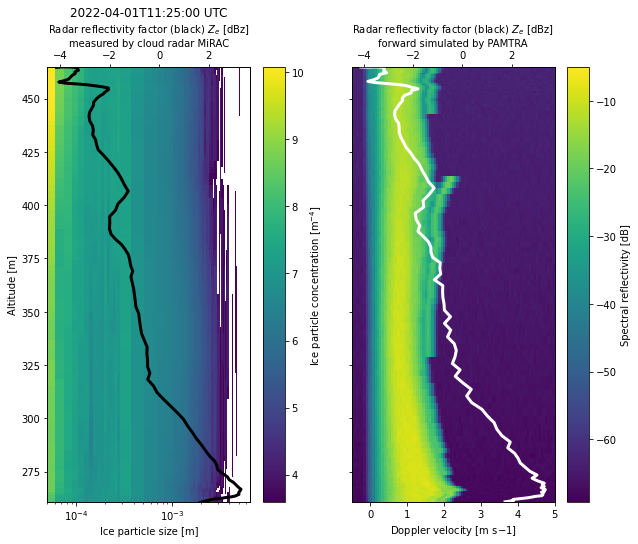

In [28]:
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(10, 8), sharey=True)

pm = ax1.pcolormesh(Dmean, data_height, data_psd_i, rasterized=True)
plt.colorbar(pm, label='Ice particle concentration [m$^{-4}$]', ax=ax1)
#ax1.plot(data_deff, data_height, c='k', lw=3)

ax1.set_xscale('log')
ax1.set_title('%s UTC' % str(data.time[0].values).split('.')[0])
ax1.set_xlabel('Ice particle size [m]')
ax1.set_ylabel('Altitude [m]')
ax1.set_xlim(50e-6,Dmean.max())

ax1t = ax1.twiny()
ax1t.plot(data_Ze, data_height, c='k', lw=3)
ax1t.set_ylim(pam_height.min(), pam_height.max())
ax1t.set_xlabel('Radar reflectivity factor (black) $Z_e$ [dBz]\nmeasured by cloud radar MiRAC')

pm = ax2.pcolormesh(pam_velocity,
                    pam_height,
                    pam_spectra,
                    vmax=-5,
                    rasterized=True)
plt.colorbar(pm, label='Spectral reflectivity [dB]', ax=ax2)

ax2.set_xlim(-0.5, 5)
ax2.set_xlabel('Doppler velocity [m s$-1$]')

ax2t = ax2.twiny()
ax2t.plot(Ze, pam_height, c='w', lw=3)
ax2t.set_ylim(pam_height.min(), pam_height.max())
ax2t.set_xlabel('Radar reflectivity factor (black) $Z_e$ [dBz]\nforward simulated by PAMTRA')

Text(0, 0.5, 'MiRAC (measured) radar reflectivity [dBZ]')

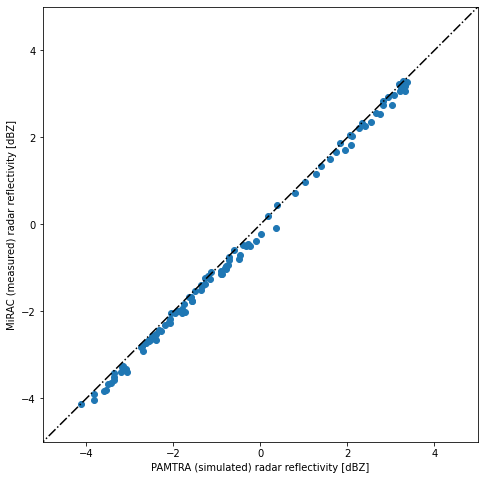

In [29]:
fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(Ze, data_Ze)
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_aspect(1)
ax.plot([-10,5], [-10,5], color='k', linestyle='-.')
ax.set_xlabel('PAMTRA (simulated) radar reflectivity [dBZ]')
ax.set_ylabel('MiRAC (measured) radar reflectivity [dBZ]')

root mean square error:

In [30]:
rmse = np.sqrt(sum((data_Ze-Ze)**2)/Ze.size)
rmse

0.15459286734178027

The results are not 1:1 the same due to: retrieval uncertanties and slightly different PAMTRA settings (e.g. standard atmosphere here instead of closest radio sonde profile). 